In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, random

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
# Checking 'train' dataframe
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [12]:
# Checking 'test' dataframe
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [13]:
# Dropping 'Id' column
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [1]:
img_width = 128
img_height = 128
img_size = (img_width, img_height)
img_channels = 3

KeyError: 0

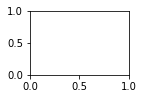

In [9]:
for i in range(6):
    plt.subplot(330+1+i)
    plt.imshow(train[i])
    plt.show()